# Modelo Gradient Boosting

### Importar Librerías

In [1]:
import pandas as pd
from pandas import DataFrame, concat
import numpy as np
from numpy import asarray
import matplotlib.pyplot as plt
import matplotlib.ticker as ticker
import matplotlib.dates as mdates
from statsmodels.tsa.holtwinters import ExponentialSmoothing
from sklearn.metrics import mean_squared_error, r2_score, mean_absolute_error
from math import sqrt
from statsmodels.nonparametric.smoothers_lowess import lowess
from sklearn.model_selection import GridSearchCV, RandomizedSearchCV, PredefinedSplit
import warnings
warnings.filterwarnings("ignore")

### 1. Cargar Datos

In [2]:
file_path = r"..\Modelling\data.csv"
data = pd.read_csv(file_path)
data['Fecha'] = pd.to_datetime(data['Fecha'])
data.set_index('Fecha', inplace=True)
data

,Ventas,Festivo,IsWeekend,DiaSemanaNum,DiaSemana_0,DiaSemana_1,DiaSemana_2,DiaSemana_3,DiaSemana_4,DiaSemana_5,DiaSemana_6,Ventas_Log,Ventas_Loess,Ventas_Log_Loess
Fecha,,,,,,,,,,,,,,
2021-11-02,80413.11,0,0,1,0,1,0,0,0,0,0,11.294945,29692.704031,10.116158
2021-11-03,14889.17,0,0,2,0,0,1,0,0,0,0,9.608457,29674.201652,10.115608
2021-11-04,50003.14,0,0,3,0,0,0,1,0,0,0,10.819861,29656.031451,10.115075
2021-11-05,39607.01,0,0,4,0,0,0,0,1,0,0,10.586787,29638.193546,10.114560
2021-11-06,0.00,0,1,5,0,0,0,0,0,1,0,0.000000,29620.685373,10.114062
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2024-07-27,305.76,0,1,5,0,0,0,0,0,1,0,5.726066,15205.174613,9.351941
2024-07-28,114.40,0,1,6,0,0,0,0,0,0,1,4.748404,15183.946452,9.350883
2024-07-29,14466.95,0,0,0,1,0,0,0,0,0,0,9.579691,15162.718291,9.349824


In [3]:
test_days=101

### 2. Definir Clases para entrenamiento

#### 2.1. Suavizado exponencial Holt-Winters

In [59]:
class HoltWintersTimeSeries:
    def __init__(self, data, target='Ventas', test_days=101, seasonal_periods=7):
        """
        Inicializa la clase con los datos, columna objetivo, tamaño de prueba y periodos estacionales.
        """
        self.data = data.copy()
        self.target = target
        self.test_days = test_days
        self.seasonal_periods = seasonal_periods

    def preprocess_data(self):
        """
        Divide los datos en conjuntos de entrenamiento y prueba.
        """
        self.train_data = self.data.iloc[:-self.test_days]
        self.test_data = self.data.iloc[-self.test_days:]

    def train_model(self, trend='add', seasonal='add', damped_trend=True):
        """
        Entrena el modelo Holt-Winters con los parámetros especificados y guarda las predicciones.
        """
        # Entrenar el modelo usando los datos de entrenamiento
        self.hw_model = ExponentialSmoothing(
                self.train_data[self.target],
                trend=trend,
                seasonal=seasonal,
                seasonal_periods=self.seasonal_periods,
                damped_trend=damped_trend
        ).fit()

        # Generar predicciones para entrenamiento y prueba con límite inferior de 0
        self.train_predictions = self.hw_model.fittedvalues.clip(lower=0)
        self.test_predictions = self.hw_model.forecast(self.test_days).clip(lower=0)

        # Crear DataFrames con valores reales y predicciones
        self.train_forecast_vs_actual = pd.DataFrame({
                'Actual': self.train_data[self.target],
                'Forecast': self.train_predictions
        }, index=self.train_data.index)

        self.test_forecast_vs_actual = pd.DataFrame({
                'Actual': self.test_data[self.target],
                'Forecast': self.test_predictions
        }, index=self.test_data.index)

        # Evaluar el desempeño
        self.evaluate_model()

    def evaluate_model(self):
        """
        Evalúa el modelo en los conjuntos de entrenamiento y prueba.
        """
        y_train = self.train_data[self.target]
        y_test = self.test_data[self.target]

        # Métricas para el conjunto de entrenamiento
        self.rmse_train = np.sqrt(mean_squared_error(y_train, self.train_predictions))
        self.mae_train = mean_absolute_error(y_train, self.train_predictions)
        self.r2_train = r2_score(y_train, self.train_predictions)

        # Métricas para el conjunto de prueba
        self.rmse_test = np.sqrt(mean_squared_error(y_test, self.test_predictions))
        self.mae_test = mean_absolute_error(y_test, self.test_predictions)
        self.r2_test = r2_score(y_test, self.test_predictions)

        # Imprimir métricas
        print(f"Entrenamiento - RMSE: {self.rmse_train:.2f}, MAE: {self.mae_train:.2f}, R²: {self.r2_train:.2f}")
        print(f"Prueba - RMSE: {self.rmse_test:.2f}, MAE: {self.mae_test:.2f}, R²: {self.r2_test:.2f}")
    
    def generate_model_info(self, version):
        model_info = {
            'version': version,
            'model_name': self.hw_model.__class__.__name__,
            'rmse_train': self.rmse_train,
            'mae_train':self.mae_train,
            'r2_train': self.r2_train,
            'rmse_test': self.rmse_test,
            'mae_test': self.mae_test,
            'r2_test': self.r2_test,
        }
        return model_info

    def plot_predictions(self, train_title, test_title, divided_title):
        """
        Genera tres gráficos personalizados con títulos proporcionados:
        1. Valores reales vs predicciones en el conjunto de entrenamiento.
        2. Valores reales vs predicciones en el conjunto de prueba.
        3. Gráfico combinado de entrenamiento y prueba con una línea divisoria.
        
        Parameters:
        - train_title: str, título para el gráfico de entrenamiento.
        - test_title: str, título para el gráfico de prueba.
        - divided_title: str, título para el gráfico con línea divisoria.
        """
        # Gráfico 1: Conjunto de entrenamiento
        plt.figure(figsize=(12, 6))
        plt.plot(self.train_forecast_vs_actual.index, self.train_forecast_vs_actual['Actual'], 
                label='Actual (Train)', marker='o', color='#1f77b4', linewidth=2, linestyle='-')
        plt.plot(self.train_forecast_vs_actual.index, self.train_forecast_vs_actual['Forecast'], 
                label='Forecast (Train)', marker='x', color='#ff7f0e', linewidth=2, linestyle='--')
        plt.title(train_title, fontsize=16, fontweight='bold', color='#333')
        plt.xlabel('Date', fontsize=14)
        plt.ylabel('Ventas', fontsize=14)
        plt.gca().xaxis.set_major_formatter(mdates.DateFormatter('%b %Y'))
        plt.xticks(rotation=45, ha='right', fontsize=10)
        formatter = ticker.FuncFormatter(lambda x, pos: '${:,.0f}K'.format(x * 1e-3))
        plt.gca().yaxis.set_major_formatter(formatter)
        plt.grid(True, which='both', axis='y', linestyle='--', alpha=0.7)
        plt.gca().set_facecolor('#f9f9f9')
        plt.legend(loc='upper left', fontsize=12)
        plt.tight_layout()
        plt.show()

        # Gráfico 2: Conjunto de prueba
        plt.figure(figsize=(12, 6))
        plt.plot(self.test_forecast_vs_actual.index, self.test_forecast_vs_actual['Actual'], 
                label='Actual (Test)', marker='o', color='#1f77b4', linewidth=2, linestyle='-')
        plt.plot(self.test_forecast_vs_actual.index, self.test_forecast_vs_actual['Forecast'], 
                label='Forecast (Test)', marker='x', color='#ff7f0e', linewidth=2, linestyle='--')
        plt.title(test_title, fontsize=16, fontweight='bold', color='#333')
        plt.xlabel('Date', fontsize=14)
        plt.ylabel('Ventas', fontsize=14)
        plt.gca().xaxis.set_major_formatter(mdates.DateFormatter('%b %Y'))
        plt.xticks(rotation=45, ha='right', fontsize=10)
        plt.gca().yaxis.set_major_formatter(formatter)
        plt.grid(True, which='both', axis='y', linestyle='--', alpha=0.7)
        plt.gca().set_facecolor('#f9f9f9')
        plt.legend(loc='upper left', fontsize=12)
        plt.tight_layout()
        plt.show()

        # Gráfico 3: Combinado con línea divisoria
        predictions = pd.concat([self.train_forecast_vs_actual['Forecast'], self.test_forecast_vs_actual['Forecast']], axis=0).to_frame(name='Predicted')
        predictions['Actual'] = pd.concat([self.train_forecast_vs_actual['Actual'], self.test_forecast_vs_actual['Actual']], axis=0)
        test_start_index = self.test_forecast_vs_actual.index.min()

        predictions_last_200 = predictions.tail(200)
        plt.figure(figsize=(12, 6))
        plt.plot(predictions_last_200.loc[:test_start_index].index, predictions_last_200.loc[:test_start_index, 'Actual'],
                label='Actual - Train', marker='o', color='#1f77b4', linewidth=2, linestyle='-')
        plt.plot(predictions_last_200.loc[:test_start_index].index, predictions_last_200.loc[:test_start_index, 'Predicted'],
                label='Forecast - Train', marker='x', color='#ff7f0e', linewidth=2, linestyle='--')
        plt.plot(predictions_last_200.loc[test_start_index:].index, predictions_last_200.loc[test_start_index:, 'Actual'],
                label='Actual - Test', marker='o', color='#2ca02c', linewidth=2, linestyle='-')
        plt.plot(predictions_last_200.loc[test_start_index:].index, predictions_last_200.loc[test_start_index:, 'Predicted'],
                label='Forecast - Test', marker='x', color='#d62728', linewidth=2, linestyle='--')

        plt.axvline(test_start_index, color='gray', linestyle='--', linewidth=1.5)
        plt.title(divided_title, fontsize=16, fontweight='bold', color='#333')
        plt.xlabel('Fecha', fontsize=14)
        plt.ylabel('Ventas (USD)', fontsize=14)
        plt.gca().xaxis.set_major_locator(mdates.DayLocator(interval=10))
        plt.gca().xaxis.set_major_formatter(mdates.DateFormatter('%d-%b'))
        plt.xticks(rotation=45, ha='right', fontsize=10)
        plt.ylim(0, 120000)  # Ajustar el rango del eje y (mejora visual)
        plt.gca().yaxis.set_major_formatter(formatter)
        plt.gca().yaxis.set_tick_params(labelsize=10)
        plt.grid(True, which='both', axis='y', linestyle='--', alpha=0.7)
        plt.gca().set_facecolor('#f9f9f9')
        plt.legend(loc='upper left', fontsize=12)
        plt.tight_layout()
        plt.show()


#### 2.2. Suavizado exponencial Holt-Winters Logarítmico

In [ ]:
class HoltWintersTimeSeriesLog(HoltWintersTimeSeries):
    """
    Extiende la funcionalidad de HoltWintersTimeSeries para trabajar con un target logarítmico.
    El target debe ser transformado como Log(Ventas + 1).
    """

    def __init__(self, data, target='Ventas_Log', test_days=101, seasonal_periods=7):
        """
        Inicializa la clase con los datos, columna objetivo y tamaño de prueba.

        Parameters:
        - data: DataFrame original.
        - target: Nombre de la variable objetivo (default: 'Ventas_Log').
        - test_days: Número de días para prueba (default: 101).
        - seasonal_periods: Número de periodos estacionales (default: 7).
        """
        super().__init__(data, target, test_days, seasonal_periods)

    def train_model(self, trend='add', seasonal='add', damped_trend=False):
        """
        Entrena el modelo Holt-Winters en la serie logarítmica.
        """
        # Entrenar el modelo usando la serie logarítmica
        self.hw_model = ExponentialSmoothing(
            self.train_data[self.target],
            trend=trend,
            seasonal=seasonal,
            seasonal_periods=self.seasonal_periods,
            damped_trend=damped_trend
        ).fit()

        # Predicciones en escala logarítmica
        self.train_predictions_log = self.hw_model.fittedvalues
        self.test_predictions_log = self.hw_model.forecast(self.test_days)

        # Deshacer la transformación logarítmica
        self.train_predictions = (np.exp(self.train_predictions_log) - 1).clip(lower=0)
        self.test_predictions = (np.exp(self.test_predictions_log) - 1).clip(lower=0)

        # Valores reales deslogaritmizados
        self.train_actual = (np.exp(self.train_data[self.target]) - 1).clip(lower=0)
        self.test_actual = (np.exp(self.test_data[self.target]) - 1).clip(lower=0)

        # Crear DataFrames con valores reales y predicciones
        self.train_forecast_vs_actual = pd.DataFrame({
            'Actual': self.train_actual,
            'Forecast': self.train_predictions
        }, index=self.train_data.index)

        self.test_forecast_vs_actual = pd.DataFrame({
            'Actual': self.test_actual,
            'Forecast': self.test_predictions
        }, index=self.test_data.index)

        # Evaluar el modelo
        self.evaluate_model()

    def evaluate_model(self):
        """
        Evalúa el modelo en los conjuntos de entrenamiento y prueba.
        Calcula las métricas RMSE, MAE y R² en los valores originales (deslogaritmizados).
        """
        # Calcular métricas para entrenamiento
        self.rmse_train = np.sqrt(mean_squared_error(self.train_actual, self.train_predictions))
        self.mae_train = mean_absolute_error(self.train_actual, self.train_predictions)
        self.r2_train = r2_score(self.train_actual, self.train_predictions)

        # Calcular métricas para prueba
        self.rmse_test = np.sqrt(mean_squared_error(self.test_actual, self.test_predictions))
        self.mae_test = mean_absolute_error(self.test_actual, self.test_predictions)
        self.r2_test = r2_score(self.test_actual, self.test_predictions)

        # Imprimir métricas
        print(f"Entrenamiento - RMSE: {self.rmse_train:.2f}, MAE: {self.mae_train:.2f}, R²: {self.r2_train:.2f}")
        print(f"Prueba - RMSE: {self.rmse_test:.2f}, MAE: {self.mae_test:.2f}, R²: {self.r2_test:.2f}")

### 3. Serie sin Transformar

In [60]:
hw_model = HoltWintersTimeSeries(data=data, target='Ventas', test_days=test_days, seasonal_periods=7)
hw_model.preprocess_data()
hw_model.train_model(trend='add', seasonal='add', damped_trend=True)

Entrenamiento - RMSE: 21772.45, MAE: 16050.58, R²: 0.39
Prueba - RMSE: 28864.94, MAE: 19914.48, R²: -0.22


Entrenamiento - RMSE: 21772.45, MAE: 16050.58, R²: 0.39
Prueba - RMSE: 28864.94, MAE: 19914.48, R²: -0.22


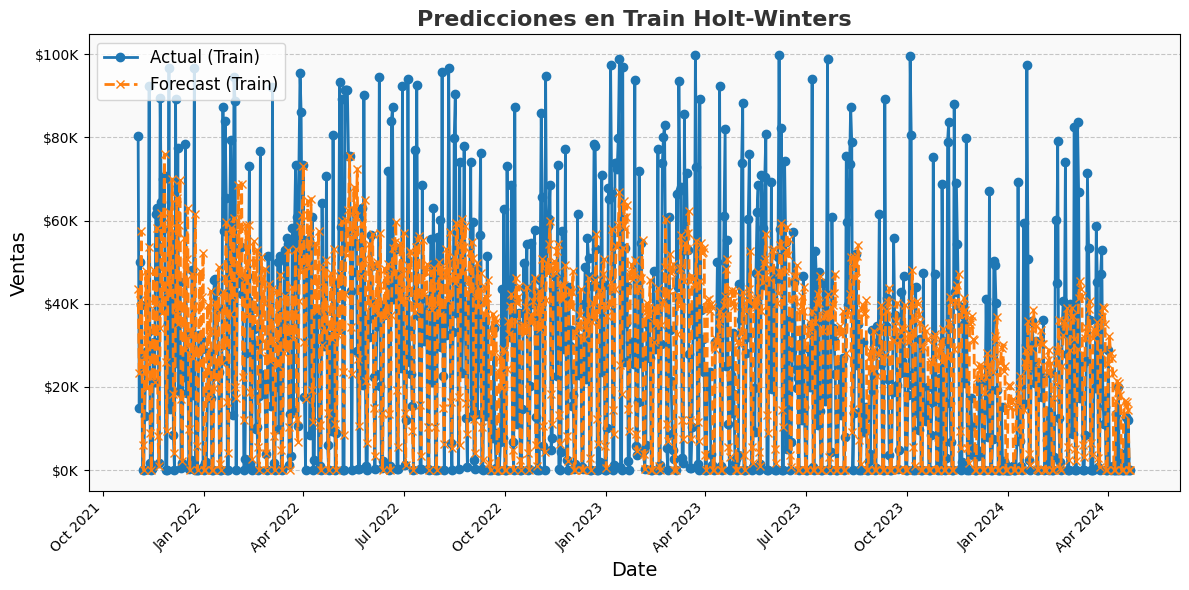

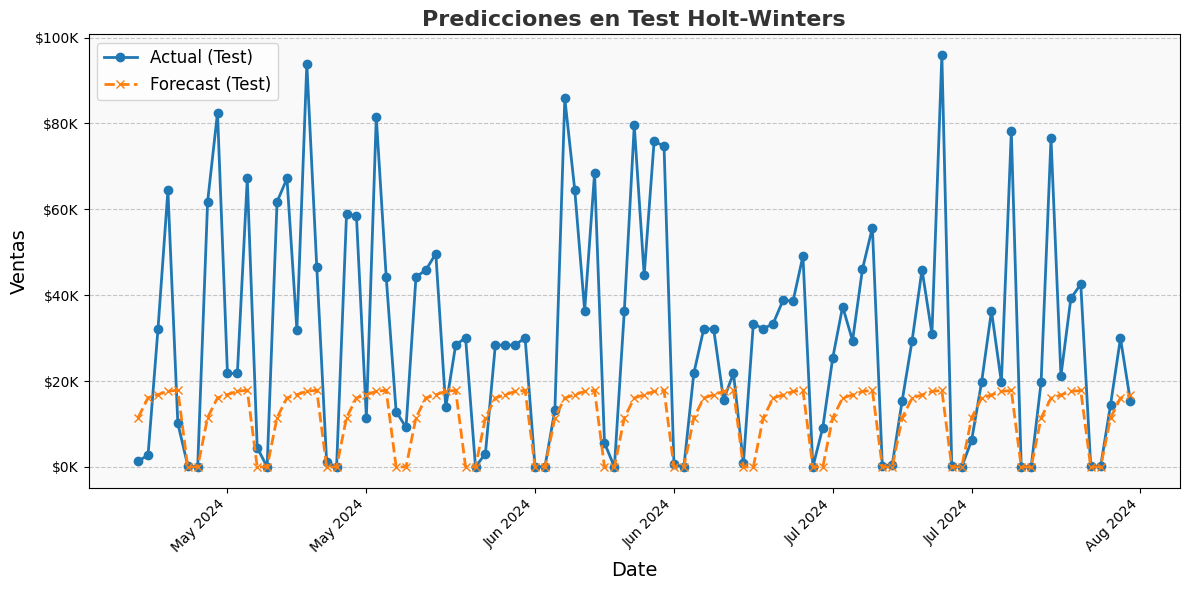

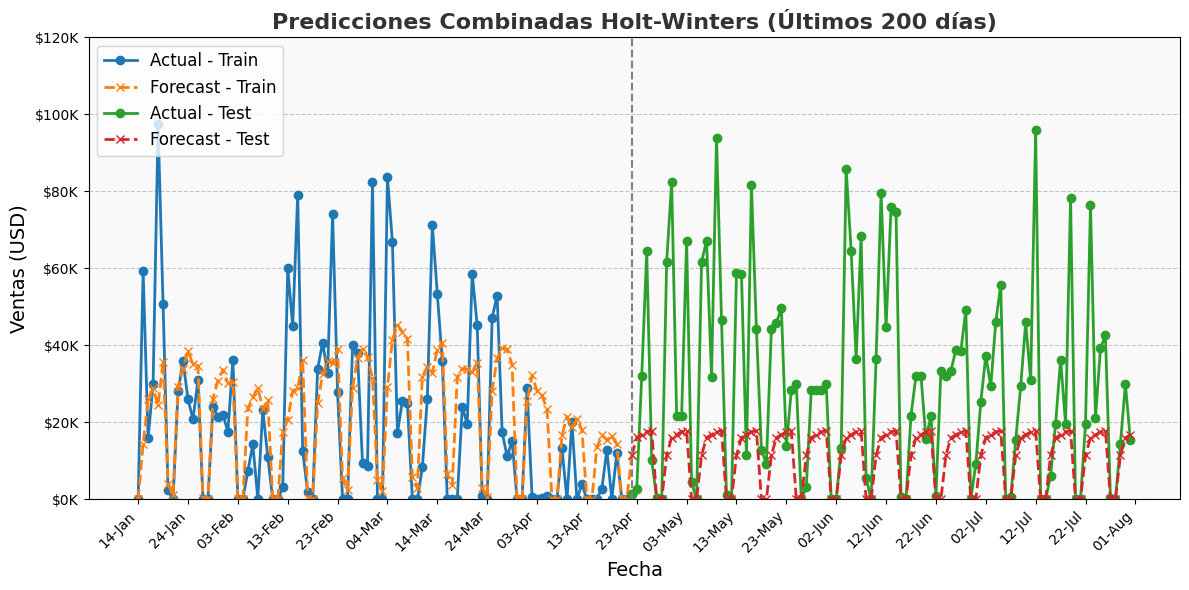

In [61]:
hw_model.evaluate_model()
hw_model.plot_predictions(train_title='Predicciones en Train Holt-Winters',
    test_title='Predicciones en Test Holt-Winters',
    divided_title='Predicciones Combinadas Holt-Winters (Últimos 200 días)'
)

In [43]:
model_info = hw_model.generate_model_info(version='Holt-Winters')

In [44]:
df_models_info = pd.DataFrame([model_info]).round(2)
df_models_info

,version,model_name,rmse_train,mae_train,r2_train,rmse_test,mae_test,r2_test
0,Holt-Winters,HoltWintersResultsWrapper,21875.94,16132.76,0.39,34673.32,25706.72,-0.77


### 4. Serie Transformada

In [48]:
hw_log_model = HoltWintersTimeSeriesLog(data=data, target='Ventas_Log', test_days=101, seasonal_periods=7)
hw_log_model.preprocess_data()
hw_log_model.train_model(trend='add', seasonal='add', damped_trend=False)

Entrenamiento - RMSE: 26988.45, MAE: 17946.32, R²: 0.07
Prueba - RMSE: 39001.47, MAE: 29369.89, R²: -1.23


Entrenamiento - RMSE: 26988.45, MAE: 17946.32, R²: 0.07
Prueba - RMSE: 39001.47, MAE: 29369.89, R²: -1.23


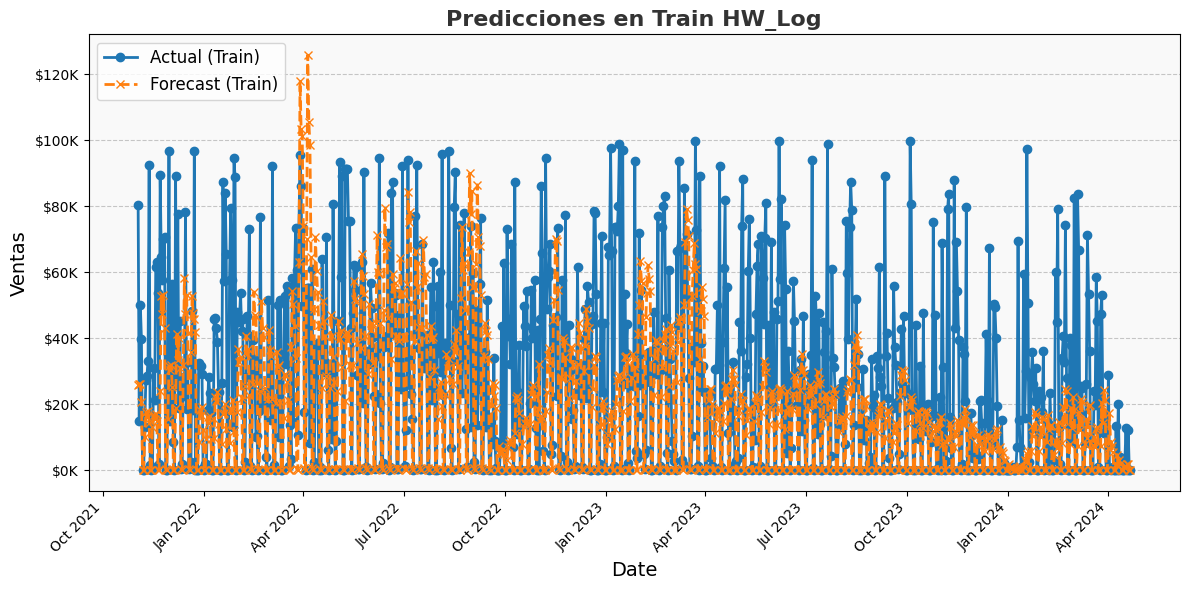

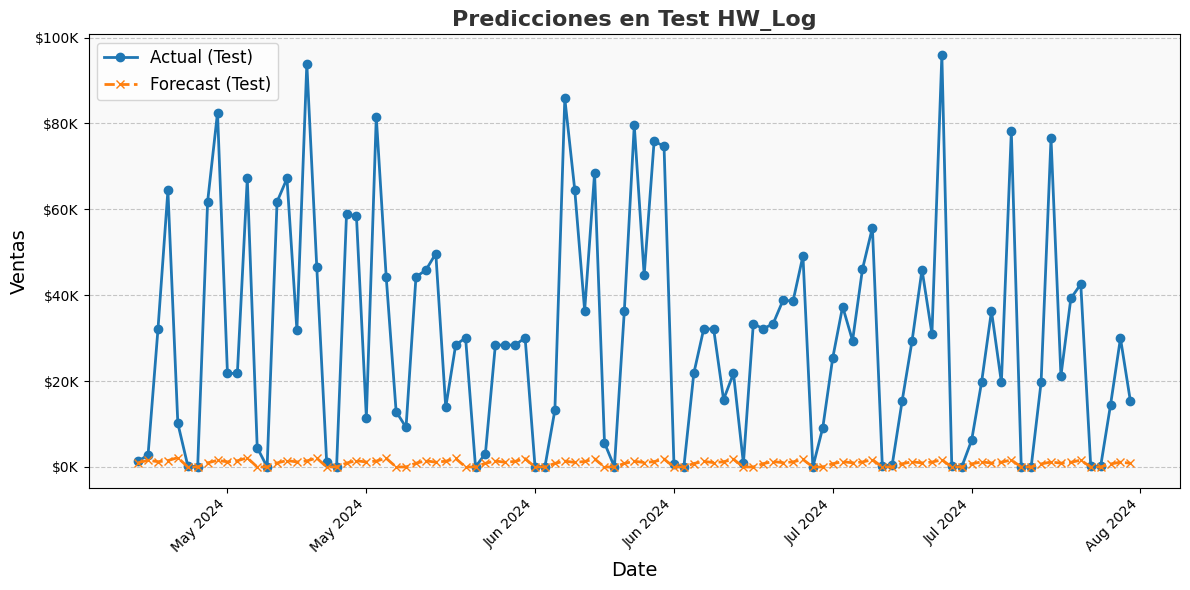

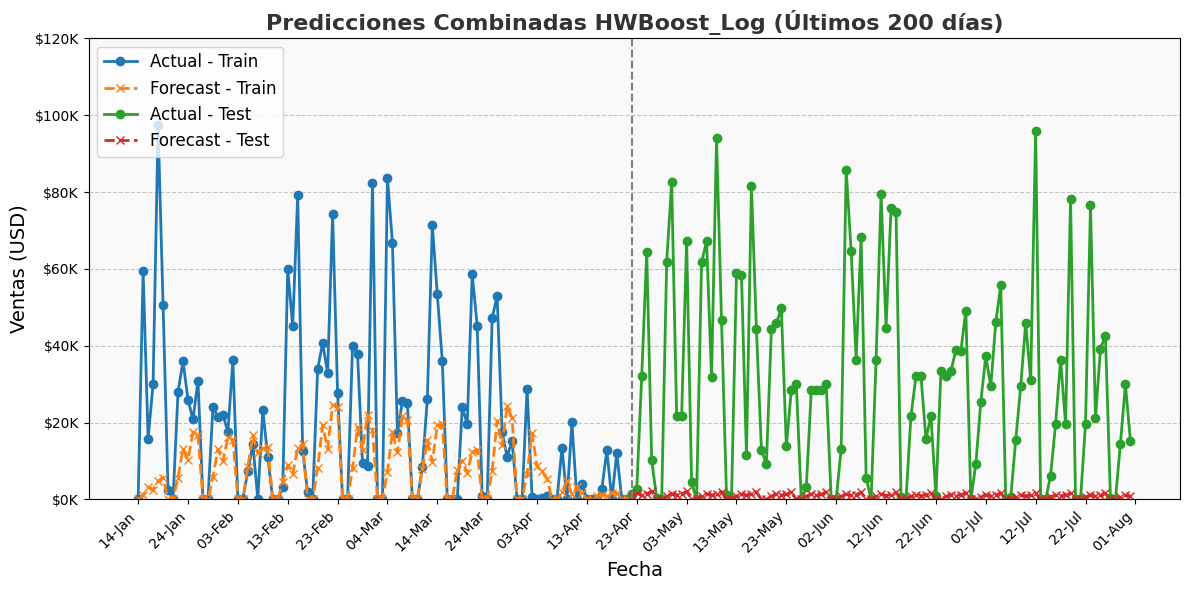

In [49]:
hw_log_model.evaluate_model()

hw_log_model.plot_predictions(train_title='Predicciones en Train HW_Log',
    test_title='Predicciones en Test HW_Log',
    divided_title='Predicciones Combinadas HWBoost_Log (Últimos 200 días)')

In [51]:
model_info_log = hw_log_model.generate_model_info(version='Holt-Winters Log')

In [52]:
df_models_info = pd.concat([df_models_info, pd.DataFrame([model_info_log])], ignore_index=True)
df_models_info

,version,model_name,rmse_train,mae_train,r2_train,rmse_test,mae_test,r2_test
0,Holt-Winters,HoltWintersResultsWrapper,21875.940000,16132.760000,0.390000,34673.320000,25706.720000,-0.770000
1,Holt-Winters Log,HoltWintersResultsWrapper,26988.450575,17946.323409,0.066928,39001.467112,29369.894547,-1.234458


### 5. Exportar Resultados

In [53]:
ruta = r'C:\Users\fsanc\OneDrive - Universidad EAFIT\Documentos\Pipe\OneDrive - Universidad EAFIT\Maestría\Trabajo de Grado\Results\holt_winters.csv'
df_models_info.to_csv(ruta, index=False)